In [4]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

import torch
import pandas as pd
import random
import torch.nn.functional as F
import numpy as np
from torch_geometric.data import Data
import torch.nn as nn
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.loader import DataLoader
import random
import torch
import torch.nn.functional as F
#from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader
from torch_geometric.nn import EdgeConv
from torch_geometric.utils import degree
from torch_geometric.nn import MessagePassing


ModuleNotFoundError: ignored

In [ ]:
FIRST_YEAR = 1995
LAST_YEAR = 2021
NUM_TRAIN = 16
NUM_VAL = 3
NUM_TEST = 6
NUM_EDGE_FEATURES = 5
EDGE_FEATURES = ['f'+str(i) for i in range(NUM_EDGE_FEATURES)]
prefix = 'https://raw.githubusercontent.com/wagles3/GNN/main/data'    

In [ ]:

def create_data(year):
    '''
    For given year, pull in node features, edge features, and edge index and
    save in a PyG Data object.
    '''
    assert(year in range(1995, 2021 + 1))
    edges = pd.read_csv(f'{prefix}/connection_{year}.csv')
    #edges = pd.read_csv(f'{prefix}/output/X_EDGE_{year}.csv')
    
    # generate map from iso_code to ids of form [0, ..., num_unique_iso_codes - 1]
    iso_codes = set(edges['i'])
    iso_codes = iso_codes.union(set(edges['j']))
    iso_code_to_id = {code : i for (i, code) in enumerate(iso_codes)}
    
    # load in edge index
    edges['i_id'] = edges['i'].map(iso_code_to_id)
    edges['j_id'] = edges['j'].map(iso_code_to_id)
    edge_index = torch.from_numpy(edges[['i_id', 'j_id']].to_numpy(np.compat.long)).t()
    edge_attr = torch.from_numpy(edges[EDGE_FEATURES].to_numpy(np.float32)) #extract the features from the dataset.
    edge_attr = (edge_attr - edge_attr.mean(axis=0)) / (edge_attr.std(axis=0))
    
    x_df = pd.read_csv(f'{prefix}/x_country_{year}.csv')
    #print(x_df)
    features = ['population','exports','imports','inflation','agri','industry','gni','netExport','fdi']

    #features = ['population']
    #x_df = pd.read_csv(f'{prefix}/output/X_NODE_{year}.csv')
    x_df['id'] = x_df['iso_code'].map(iso_code_to_id)
    x = torch.from_numpy(x_df.sort_values('id').loc[:,features].to_numpy(np.float32))
    x = (x - x.mean(axis=0)) / (x.std(axis=0))  # scale and center data
    # load in target values
    y_df = pd.read_csv(f'{prefix}/y_country_{year}.csv')
    #y_df = pd.read_csv(f'{prefix}/output/Y_{year}.csv')
    y_df['id'] = y_df['iso_code'].map(iso_code_to_id)
    y = torch.from_numpy(y_df.sort_values('id')['gdp'].to_numpy(np.float32)).unsqueeze(1)# get labels as tensor
    y = y.log() # log scale since spread of GDP is large
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

    
def evaluate_model(model, data_iter):
    '''
    Accumulate MSE over a data list or loader.
    '''
    return sum([F.mse_loss(model(data), data.y).item() for data in data_iter])

def get_data():
    '''
    Generate data_lists for train, val, and test. These lists can be either loaded into data_loaders
    or indexed directly.
    '''

    data_list = [create_data(year) for year in range(FIRST_YEAR, LAST_YEAR)]

    random.shuffle(data_list)
    data_train = data_list[:NUM_TRAIN]
    data_val = data_list[NUM_TRAIN:NUM_TRAIN+NUM_VAL+1]
    data_test = data_list[NUM_TRAIN+NUM_VAL:]
    return (data_train, data_val, data_test)

In [ ]:
data_train, data_val, data_test = get_data()
print(data_train)

[Data(x=[189, 9], edge_index=[2, 11095], edge_attr=[11095, 10], y=[189, 1]), Data(x=[198, 9], edge_index=[2, 13409], edge_attr=[13409, 10], y=[198, 1]), Data(x=[187, 9], edge_index=[2, 9506], edge_attr=[9506, 10], y=[187, 1]), Data(x=[204, 9], edge_index=[2, 13947], edge_attr=[13947, 10], y=[204, 1]), Data(x=[198, 9], edge_index=[2, 13048], edge_attr=[13048, 10], y=[198, 1]), Data(x=[198, 9], edge_index=[2, 13059], edge_attr=[13059, 10], y=[198, 1]), Data(x=[200, 9], edge_index=[2, 13791], edge_attr=[13791, 10], y=[200, 1]), Data(x=[204, 9], edge_index=[2, 13008], edge_attr=[13008, 10], y=[204, 1]), Data(x=[204, 9], edge_index=[2, 13250], edge_attr=[13250, 10], y=[204, 1]), Data(x=[201, 9], edge_index=[2, 12289], edge_attr=[12289, 10], y=[201, 1]), Data(x=[204, 9], edge_index=[2, 12977], edge_attr=[12977, 10], y=[204, 1]), Data(x=[198, 9], edge_index=[2, 13022], edge_attr=[13022, 10], y=[198, 1]), Data(x=[198, 9], edge_index=[2, 13889], edge_attr=[13889, 10], y=[198, 1]), Data(x=[187, 

In [ ]:
print(len(data_train))
print(len(data_test))
print(len(data_val))
print(type(data_train[0].x[0]))



16
7
4
<class 'torch.Tensor'>


In [ ]:
import torch.nn as nn
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.loader import DataLoader
import random

class BaselineGDPModel(torch.nn.Module):
    def __init__(self, num_features=9, hidden_size=128, target_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_features = num_features
        self.target_size = target_size
        self.convs = [GCNConv(self.num_features, self.hidden_size)]
        for l in range(1):
            self.convs.append(GCNConv(self.hidden_size, self.hidden_size))
        self.linear = nn.Linear(self.hidden_size, 32)
        self.linear2 = nn.Linear(32, self.target_size)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        for conv in self.convs[:-1]: 
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
        x = self.convs[-1](x, edge_index) 
        emb = x
        x = self.linear(x).relu()
        x = self.linear2(x)
        return F.relu(x) 

In [ ]:

import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader
from torch_geometric.utils import degree
from torch_geometric.nn import MessagePassing

class GDPModel(torch.nn.Module):
    def __init__(self, num_features=9, hidden_size=32, target_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_features = num_features
        self.target_size = target_size
        self.convs = [GATConv(self.num_features, self.hidden_size, edge_dim = NUM_EDGE_FEATURES),
                      GATConv(self.hidden_size, self.hidden_size, edge_dim = NUM_EDGE_FEATURES)]
        self.linear = nn.Linear(self.hidden_size, 32)
        self.linear2 = nn.Linear(32, self.target_size)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        for conv in self.convs[:-1]:
            x = conv(x, edge_index, edge_attr=edge_attr)  #additional edge feature provided
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
        x = self.convs[-1](x, edge_index, edge_attr=edge_attr)
        x = self.linear(x).relu()
        x = self.linear2(x)

        return F.relu(x) 


In [ ]:
hyperparams = {
    'batch_size' : 1, 
    'save_loss_interval' :10, 
    'print_interval' : 20,
    'save_model_interval' : 10,
    'n_epochs' : 500,
    'learning_rate' : 0.01
}

In [ ]:
plot_loss_train= []
plot_loss_val=[]
plot_loss_epoch=[]
def train(model, name_prefix, hyperparams):
   
    learning_rate = hyperparams['learning_rate']
    batch_size = hyperparams['batch_size']
    n_epochs = hyperparams['n_epochs']
    save_loss_interval = hyperparams['save_loss_interval']
    print_interval = hyperparams['print_interval']
    save_model_interval = hyperparams['save_model_interval']

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = 0.001)
    loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
    tst_loader = DataLoader(data_test, batch_size=batch_size, shuffle=True)

    losses = []
    test_data = data_test[0]
    for epoch in range(n_epochs):
        epoch_loss = 0
        model.train()
        for data in loader:
            optimizer.zero_grad()
            out = model(data)
            loss = F.mse_loss(out, data.y)
            epoch_loss += loss.item() 
            loss.backward()
            optimizer.step()
        if epoch % save_loss_interval == 0:
            val_loss = evaluate_model(model, data_val) / NUM_VAL
            train_loss = epoch_loss / NUM_TRAIN * batch_size
            plot_loss_train.append(train_loss)
            plot_loss_val.append(val_loss)
            plot_loss_epoch.append(epoch)

            test_acc = test(tst_loader, model)
            if epoch % print_interval == 0:
                print("Epoch: {} Train loss: {:.2e} Validation loss: {:.2e} Test accuracy: {:.2f}".format(epoch, train_loss, val_loss, test_acc))
            losses.append((epoch, train_loss, val_loss, test_acc))
        if epoch % save_model_interval == 0:
            # save predictions for plotting
            model.eval()

    return losses

In [ ]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

def test(loader, model):
    model.eval()
    #print("Test is happening")
    y_true, y_pred = [], []
    for data in loader:
        output = model(data)
        y_true.append(data.y.numpy())
        y_pred.append(output.detach().cpu().numpy())
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    r2 = r2_score(y_true, y_pred)
    return r2


'\ndef test(loader, model, is_validation=False):\n    model.eval()\n\n    correct = 0\n    for data in loader:\n        with torch.no_grad():\n            pred = model(data)\n            pred = pred.argmax(dim=1)\n            label = data.y\n        correct += pred.eq(label).sum().item()\n    \n        total = len(loader.dataset) \n    return correct / total\n'

In [ ]:
print("Training baseline 128, mlp=1...")
baseline = BaselineGDPModel()
baseline_loss_traj = train(baseline, "baseline", hyperparams)


Training baseline 128, mlp=1...


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0 Train loss: 4.18e+01 Validation loss: 4.14e+01 Test accuracy: -10.90
Epoch: 20 Train loss: 1.55e+00 Validation loss: 1.95e+00 Test accuracy: 0.44
Epoch: 40 Train loss: 1.41e+00 Validation loss: 1.84e+00 Test accuracy: 0.46
Epoch: 60 Train loss: 1.43e+00 Validation loss: 2.11e+00 Test accuracy: 0.38
Epoch: 80 Train loss: 1.42e+00 Validation loss: 1.80e+00 Test accuracy: 0.47
Epoch: 100 Train loss: 1.38e+00 Validation loss: 1.73e+00 Test accuracy: 0.50
Epoch: 120 Train loss: 1.52e+00 Validation loss: 2.01e+00 Test accuracy: 0.45
Epoch: 140 Train loss: 1.82e+00 Validation loss: 2.55e+00 Test accuracy: 0.27
Epoch: 160 Train loss: 1.34e+00 Validation loss: 2.03e+00 Test accuracy: 0.40
Epoch: 180 Train loss: 1.37e+00 Validation loss: 2.04e+00 Test accuracy: 0.44
Epoch: 200 Train loss: 1.38e+00 Validation loss: 1.70e+00 Test accuracy: 0.51
Epoch: 220 Train loss: 1.37e+00 Validation loss: 1.72e+00 Test accuracy: 0.51
Epoch: 240 Train loss: 1.27e+00 Validation loss: 1.79e+00 Test accur

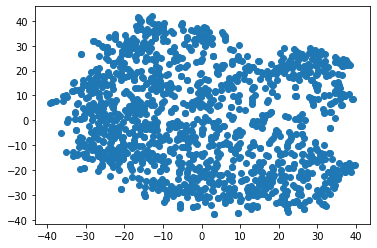

In [ ]:
#Need to use this function carefully, because it plots the node embeddings
'''

#color_list = ["red", "orange", "green", "blue", "purple", "brown"]
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
loader = DataLoader(data_test, batch_size=1, shuffle=True)
embs = []
colors = []
baseline = BaselineGDPModel()
for batch in loader:
    emb, pred = baseline(batch)
    embs.append(emb)
    #colors += [color_list[y] for y in batch.y]
embs = torch.cat(embs, dim=0)

xs, ys = zip(*TSNE().fit_transform(embs.detach().numpy()))
plt.scatter(xs, ys)
'''


In [ ]:
from torch_geometric.nn import GAE

import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GAE



# Define encoder with two GCNConv layers
class GCNEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        #self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        #x = self.conv2(x, edge_index)
        return x

# Define decoder with two GCNConv layers
class GCNDecoder(nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super(GCNDecoder, self).__init__()
        self.conv1 = GCNConv(hidden_channels, out_channels)
        self.conv2 = GCNConv(out_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Define GAE model with two GCNConv layers
#
class GAE_Model(nn.Module):
    def __init__(self, in_channels=9, hidden_channels=128, out_channels=1):
        super(GAE_Model, self).__init__()
        self.conv = GCNConv(in_channels, hidden_channels)
        #self.conv.add_module("emod1",GCNConv(in_channels, hidden_channels))
        #self.encoder = GCNConv(in_channels, hidden_channels)
        self.decoder = GCNConv(hidden_channels, out_channels)
        #self.dropout = nn.Dropout(dropout)
        self.gae = GAE(self.conv, self.decoder)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        z = self.conv(x, edge_index)
        x_hat = self.decoder(z,edge_index)
        return x_hat


In [ ]:
gae_model = GAE_Model()
gae_model_loss_traj = train(gae_model, "model", hyperparams)

/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0 Train loss: 3.76e+01 Validation loss: 3.41e+01 Test accuracy: -9.83
Epoch: 20 Train loss: 1.14e+01 Validation loss: 1.59e+01 Test accuracy: -4.04
Epoch: 40 Train loss: 4.90e+00 Validation loss: 7.21e+00 Test accuracy: -1.17
Epoch: 60 Train loss: 2.37e+00 Validation loss: 3.44e+00 Test accuracy: -0.02
Epoch: 80 Train loss: 1.61e+00 Validation loss: 2.26e+00 Test accuracy: 0.32
Epoch: 100 Train loss: 1.45e+00 Validation loss: 1.95e+00 Test accuracy: 0.40
Epoch: 120 Train loss: 1.43e+00 Validation loss: 1.87e+00 Test accuracy: 0.42
Epoch: 140 Train loss: 1.42e+00 Validation loss: 1.86e+00 Test accuracy: 0.42
Epoch: 160 Train loss: 1.41e+00 Validation loss: 1.85e+00 Test accuracy: 0.42
Epoch: 180 Train loss: 1.42e+00 Validation loss: 1.88e+00 Test accuracy: 0.41
Epoch: 200 Train loss: 1.43e+00 Validation loss: 1.85e+00 Test accuracy: 0.42
Epoch: 220 Train loss: 1.42e+00 Validation loss: 1.87e+00 Test accuracy: 0.42
Epoch: 240 Train loss: 1.41e+00 Validation loss: 1.84e+00 Test acc

In [ ]:
print("Training model...for five edge features 32 neurons, MLP")
model = GDPModel() # needs to be double precision
model_loss_traj_five = train(model, "model", hyperparams)

Training model...for five edge features , MLP


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0 Train loss: 3.38e+01 Validation loss: 2.07e+01 Test accuracy: -3.27
Epoch: 20 Train loss: 1.26e+00 Validation loss: 1.84e+00 Test accuracy: 0.52
Epoch: 40 Train loss: 1.39e+00 Validation loss: 1.93e+00 Test accuracy: 0.46
Epoch: 60 Train loss: 1.23e+00 Validation loss: 1.68e+00 Test accuracy: 0.55
Epoch: 80 Train loss: 1.24e+00 Validation loss: 1.83e+00 Test accuracy: 0.53
Epoch: 100 Train loss: 1.10e+00 Validation loss: 1.61e+00 Test accuracy: 0.56
Epoch: 120 Train loss: 1.63e+00 Validation loss: 1.69e+00 Test accuracy: 0.54
Epoch: 140 Train loss: 1.09e+00 Validation loss: 1.68e+00 Test accuracy: 0.55
Epoch: 160 Train loss: 1.31e+00 Validation loss: 2.38e+00 Test accuracy: 0.36
Epoch: 180 Train loss: 1.25e+00 Validation loss: 2.24e+00 Test accuracy: 0.44
Epoch: 200 Train loss: 1.08e+00 Validation loss: 1.96e+00 Test accuracy: 0.49
Epoch: 220 Train loss: 1.12e+00 Validation loss: 1.51e+00 Test accuracy: 0.58
Epoch: 240 Train loss: 1.19e+00 Validation loss: 1.48e+00 Test accura

In [ ]:
print("Training model with 10 features and increasing number of hidden layer neurons to 128, mlp=1...")
model = GDPModel() # needs to be double precision
model_loss_traj_ten = train(model, "model", hyperparams)

Training model with 10 features and increasing number of hidden layer neurons to 128, mlp=1...


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0 Train loss: 4.67e+01 Validation loss: 2.99e+01 Test accuracy: -7.47
Epoch: 20 Train loss: 1.45e+00 Validation loss: 1.89e+00 Test accuracy: 0.48
Epoch: 40 Train loss: 1.35e+00 Validation loss: 1.74e+00 Test accuracy: 0.49
Epoch: 60 Train loss: 1.25e+00 Validation loss: 1.57e+00 Test accuracy: 0.52
Epoch: 80 Train loss: 1.62e+00 Validation loss: 1.60e+00 Test accuracy: 0.53
Epoch: 100 Train loss: 1.36e+00 Validation loss: 1.57e+00 Test accuracy: 0.50
Epoch: 120 Train loss: 1.37e+00 Validation loss: 1.51e+00 Test accuracy: 0.54
Epoch: 140 Train loss: 1.25e+00 Validation loss: 1.91e+00 Test accuracy: 0.46
Epoch: 160 Train loss: 1.36e+00 Validation loss: 1.60e+00 Test accuracy: 0.53
Epoch: 180 Train loss: 1.26e+00 Validation loss: 1.49e+00 Test accuracy: 0.54
Epoch: 200 Train loss: 1.27e+00 Validation loss: 1.59e+00 Test accuracy: 0.54
Epoch: 220 Train loss: 1.32e+00 Validation loss: 1.71e+00 Test accuracy: 0.50
Epoch: 240 Train loss: 1.31e+00 Validation loss: 1.48e+00 Test accura

In [ ]:
print("Training model with 10 features and increasing number of hidden layer neurons to 128, mlp=1...")
model_pred_1 = GDPModel() # needs to be double precision
model_pred_epoch100 = train(model_pred_1, "model", hyperparams)

Training model with 10 features and increasing number of hidden layer neurons to 128, mlp=1...


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0 Train loss: 3.93e+01 Validation loss: 2.11e+01 Test accuracy: -5.72
Epoch: 1 Train loss: 1.66e+01 Validation loss: 1.65e+01 Test accuracy: -3.36
Epoch: 2 Train loss: 1.04e+01 Validation loss: 1.26e+01 Test accuracy: -1.98
Epoch: 3 Train loss: 8.19e+00 Validation loss: 1.18e+01 Test accuracy: -1.68
Epoch: 4 Train loss: 7.26e+00 Validation loss: 9.50e+00 Test accuracy: -1.11
Epoch: 5 Train loss: 6.23e+00 Validation loss: 7.59e+00 Test accuracy: -0.79
Epoch: 6 Train loss: 5.47e+00 Validation loss: 7.72e+00 Test accuracy: -0.71
Epoch: 7 Train loss: 4.76e+00 Validation loss: 5.62e+00 Test accuracy: -0.27
Epoch: 8 Train loss: 3.80e+00 Validation loss: 5.11e+00 Test accuracy: -0.05
Epoch: 9 Train loss: 2.89e+00 Validation loss: 3.62e+00 Test accuracy: 0.10
Epoch: 10 Train loss: 2.58e+00 Validation loss: 3.14e+00 Test accuracy: 0.25
Epoch: 11 Train loss: 2.20e+00 Validation loss: 2.74e+00 Test accuracy: 0.34
Epoch: 12 Train loss: 1.90e+00 Validation loss: 2.40e+00 Test accuracy: 0.37


In [ ]:
print("Training model with 15 features number of neurons to 128")
model = GDPModel() # needs to be double precision
model_loss_traj_fifteen = train(model, "model", hyperparams)

Training model with 15 features number of neurons to 128


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0 Train loss: 5.75e+01 Validation loss: 6.50e+01 Test accuracy: -17.54
Epoch: 20 Train loss: 7.96e+00 Validation loss: 1.20e+01 Test accuracy: -1.77
Epoch: 40 Train loss: 5.49e+00 Validation loss: 7.62e+00 Test accuracy: -0.69
Epoch: 60 Train loss: 3.93e+00 Validation loss: 5.76e+00 Test accuracy: -0.19
Epoch: 80 Train loss: 2.81e+00 Validation loss: 4.34e+00 Test accuracy: 0.11
Epoch: 100 Train loss: 2.17e+00 Validation loss: 3.30e+00 Test accuracy: 0.30
Epoch: 120 Train loss: 1.78e+00 Validation loss: 2.34e+00 Test accuracy: 0.38
Epoch: 140 Train loss: 1.53e+00 Validation loss: 2.20e+00 Test accuracy: 0.45
Epoch: 160 Train loss: 1.43e+00 Validation loss: 2.00e+00 Test accuracy: 0.49
Epoch: 180 Train loss: 1.36e+00 Validation loss: 1.97e+00 Test accuracy: 0.50
Epoch: 200 Train loss: 1.32e+00 Validation loss: 1.85e+00 Test accuracy: 0.52
Epoch: 220 Train loss: 1.31e+00 Validation loss: 1.70e+00 Test accuracy: 0.52
Epoch: 240 Train loss: 1.28e+00 Validation loss: 1.72e+00 Test ac

In [ ]:
print("Training model with 20 features number of neurons to 256, mlp=2")
model = GDPModel() # needs to be double precision
model_loss_traj_twentyH2 = train(model, "model", hyperparams)

Training model with 20 features number of neurons to 256, mlp=2


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0 Train loss: 2.90e+01 Validation loss: 1.91e+01 Test accuracy: -5.15
Epoch: 20 Train loss: 1.37e+00 Validation loss: 1.90e+00 Test accuracy: 0.50
Epoch: 40 Train loss: 1.40e+00 Validation loss: 1.86e+00 Test accuracy: 0.43
Epoch: 60 Train loss: 1.30e+00 Validation loss: 1.63e+00 Test accuracy: 0.36
Epoch: 80 Train loss: 1.41e+00 Validation loss: 1.65e+00 Test accuracy: 0.43
Epoch: 100 Train loss: 1.16e+00 Validation loss: 1.49e+00 Test accuracy: 0.55
Epoch: 120 Train loss: 1.40e+00 Validation loss: 2.01e+00 Test accuracy: 0.47
Epoch: 140 Train loss: 1.33e+00 Validation loss: 2.22e+00 Test accuracy: 0.02
Epoch: 160 Train loss: 1.12e+00 Validation loss: 1.34e+00 Test accuracy: 0.50
Epoch: 180 Train loss: 1.29e+00 Validation loss: 1.51e+00 Test accuracy: 0.48
Epoch: 200 Train loss: 1.32e+00 Validation loss: 1.40e+00 Test accuracy: 0.43
Epoch: 220 Train loss: 1.14e+00 Validation loss: 1.46e+00 Test accuracy: 0.40
Epoch: 240 Train loss: 1.20e+00 Validation loss: 1.31e+00 Test accura

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

def comparison_plot(baseline_loss_traj, model_loss_traj, gae_model_loss_traj):
    plt.yscale('log') 
    _, _, baseline_val,base_acc = tuple(zip(*baseline_loss_traj))
    epoch, _, model_val,model_acc = tuple(zip(*model_loss_traj))
    _, _, gae_model_val,gae_acc = tuple(zip(*gae_model_loss_traj))
    plt.plot(epoch, baseline_val, '-r', label='GAT Model (5 edge features)')
    plt.plot(epoch, model_val, '-b', label='GAT Model (10 edge features)')
    plt.plot(epoch, gae_model_val, '-g', label='GAE Model ')
    plt.legend(loc='upper right', title='ANN Models:')
    plt.yscale('log')
    plt.ylabel('MSE (in log scale)')
    plt.xlabel('number of epochs')
    plt.title(f'Comparing Loss trajectory of GNN models for 128 hidden neurons')
    plt.show()
    plt.clf()

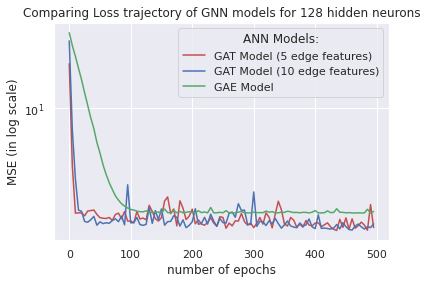

<Figure size 432x288 with 0 Axes>

In [ ]:
comparison_plot(model_loss_traj_five, model_loss_traj_ten, gae_model_loss_traj)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

def comparison_plot_test(baseline_loss_traj, model_loss_traj, gae_model_loss_traj):
    plt.yscale('log') 
    _, _, baseline_val,base_acc = tuple(zip(*baseline_loss_traj))
    epoch, _, model_val,model_acc = tuple(zip(*model_loss_traj))
    _, _, gae_model_val,gae_acc = tuple(zip(*gae_model_loss_traj))
    plt.plot(epoch, base_acc, '-r', label='GCN Model (Baseline)')
    plt.plot(epoch, model_acc, '-b', label='GAT Model (10 edge features)')
    plt.plot(epoch, gae_acc, '-g', label='GAE Model')
    plt.legend(loc='lower right', title='ANN Models:')
    plt.yscale('log')
    plt.ylabel('Accuracy')
    plt.xlabel('number of epochs')
    plt.title(f'Comparing Test accuracy of different models')
    plt.show()
    plt.clf()

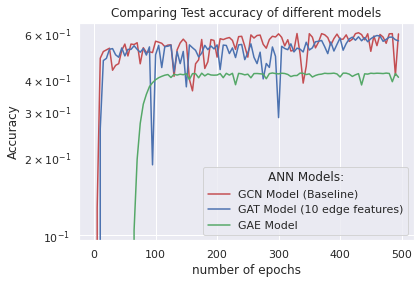

<Figure size 432x288 with 0 Axes>

In [ ]:
comparison_plot_test(model_loss_traj_five, model_loss_traj_ten, gae_model_loss_traj)


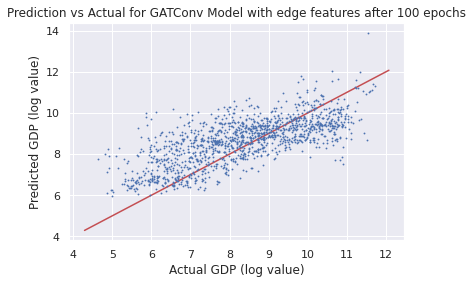

In [ ]:
model_out =[]
preds = []
for data in data_test:
  model_out += list(data.y.detach().numpy().squeeze())
  preds += list(model_pred_1(data).detach().numpy().squeeze())
max_x = max(model_out)
max_x *= 1.15
plt.scatter(model_out, preds, s=.7, zorder=2)
l, r = plt.xlim()
plt.plot([l, r], [l, r], c='r', zorder=1)
plt.xlabel("Actual GDP (log value)")
plt.ylabel("Predicted GDP (log value)")
plt.title("Prediction vs Actual for GATConv Model with edge features after 100 epochs")
plt.show()